In [1]:
'''
development python version:3.8.13
author: Siao-Yu Jian
function: Data preprocess and Model training
version history:
                2023.03.23      version v2.0.3      initial version
                2023.03.24      version v2.0.4      change train test split to sklearn train_test_split for fix price shiffting     
'''
import os
import math
import numpy as np
import pandas as pd
import ccxt
import talib
from datetime import datetime
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from script.fetch_history_data import binance_fetch_history_price, binance_single_fetch_history_price
from script.preprocess import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from script.transformer_timestep import *
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.5 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Tensorflow version: 2.6.5


In [2]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
valid_percent = 20
test_percent = 10

target_column='Close_MA_ptc_10'
pearson_corr_cutoff = 0.2

model_weight_path = './model_weight/transformer_eth_multi_factor_v2.0.4.hdf5'
# with open('multi_factor_v2.0.1.pickle', 'rb') as input_pickle:
#     multi_factor_dic = pickle.load(input_pickle)

# zscore_col = multi_factor_dic['zscore'][0]
# zscore_std = multi_factor_dic['zscore'][1]
# zscore_mean = multi_factor_dic['zscore'][2]
# input_col = multi_factor_dic['input_col']

In [3]:
def calculate_z_score_input_format(df_cal):
    for col in zscore_col:
        df_cal[col] = (df_cal[col] - zscore_mean) / zscore_std
    df_cal['Volume_zscore'] = (df_cal['Volume'] - vol_zscore_mean) / vol_zscore_std
    return df_cal[input_col], df_cal

## Data lock for hyper-parameter & trace bug

In [4]:
df = binance_fetch_history_price(coin='ETH/USDT', timeframe='1h', start_date='2019-09-10')
timeframes = [10,20,40,60,80,100,120,140,160,180,200]
df_cal = calculate_technical_indicators(df, timeframes=timeframes)
df_train, df_val, df_test = preprocess_train_test_split(df_cal, valid_percent=valid_percent, test_percent=test_percent)
df_cal.to_pickle('./data/eth_multi_factor_v2.0.4.pickle')

#### Generate the Z-score std mean dictionary & Using pearson correlation to filter features 

In [5]:
df_cal = pd.read_pickle('./data/eth_multi_factor_v2.0.4.pickle')
df_drop_timestamp = df_cal.copy()
del df_drop_timestamp['Timestamp']
# change to sklearn to split train test set
df_train, df_test = train_test_split(df_drop_timestamp, random_state=0, train_size=0.9, shuffle=False)
df_train, df_val = train_test_split(df_train, random_state=0, train_size=0.9, shuffle=False)
#df_train, df_val, df_test = preprocess_train_test_split(df_cal, valid_percent=valid_percent, test_percent=test_percent)
df_cal_drop_col = df_train.copy()

# select MA columns to calculate Z-score
#del df_cal_drop_col['Timestamp']
ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
ma_ptc_col += ['ZhangDieFu', 'ZhenFu']	
zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()


# select Volume to calculate Z-score    
vol_zscore_std = df_cal_drop_col['Volume'].values.reshape(-1).std()
vol_zscore_mean = df_cal_drop_col['Volume'].values.reshape(-1).mean()
df_cal_drop_col['Volume_zscore'] = (df_cal_drop_col['Volume'] - vol_zscore_mean) / vol_zscore_std


# # select Volume_ma_ptc_col to calculate Z-score    
# vol_ma_col = [col for col in df_cal_drop_col.columns if 'Volume_MA' in col and 'ptc' not in col and col != 'Timestamp']
# vol_ma_zscore_std = df_cal_drop_col[vol_ma_col].values.reshape(-1).std()
# vol_ma_zscore_mean = df_cal_drop_col[vol_ma_col].values.reshape(-1).mean()
# for col in vol_ma_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - vol_ma_zscore_mean) / vol_ma_zscore_std

# # select Volume_ma_ptc_col to calculate Z-score    
# vol_ma_ptc_col = [col for col in df_cal_drop_col.columns if 'Volume_MA_ptc_' in col and col != 'Timestamp']
# vol_ma_ptc_zscore_std = df_cal_drop_col[vol_ma_ptc_col].values.reshape(-1).std()
# vol_ma_ptc_zscore_mean = df_cal_drop_col[vol_ma_ptc_col].values.reshape(-1).mean()
# for col in vol_ma_ptc_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - vol_ma_ptc_zscore_mean) / vol_ma_ptc_zscore_std

# pearson corr filter
filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]
#minmax_df = df_cal_drop_col[filterd_col]

# save z-score to dictionary
multi_factor_dic = {}
multi_factor_dic['zscore'] = [ma_ptc_col, zscore_std, zscore_mean]
multi_factor_dic['vol_zscore'] = ['Volume', vol_zscore_std, vol_zscore_mean]
#multi_factor_dic['vol_ma_ptc_zscore'] = [vol_ma_ptc_col, vol_ma_ptc_zscore_std, vol_ma_ptc_zscore_mean]
multi_factor_dic['input_col'] = filterd_col + ['Volume_zscore']

with open('./normalization/eth_multi_factor_v2.0.4.pickle', 'wb') as input_pickle:
    pickle.dump(multi_factor_dic, input_pickle)

In [6]:
df_cal_drop_col.corr()[target_column].abs()['Volume_zscore']

0.11029188522866228

In [7]:
with open('./normalization/eth_multi_factor_v2.0.4.pickle', 'rb') as input_pickle:
    multi_factor_dic = pickle.load(input_pickle)

zscore_col = multi_factor_dic['zscore'][0]
zscore_std = multi_factor_dic['zscore'][1]
zscore_mean = multi_factor_dic['zscore'][2]
vol_zscore_col = multi_factor_dic['vol_zscore'][0]
vol_zscore_std = multi_factor_dic['vol_zscore'][1]
vol_zscore_mean = multi_factor_dic['vol_zscore'][2]
input_col = multi_factor_dic['input_col']

In [8]:
df_train_zscore, df_train_zscore_total = calculate_z_score_input_format(df_train)
df_val_zscore, df_val_zscore_total = calculate_z_score_input_format(df_val)
df_test_zscore, df_test_zscore_total = calculate_z_score_input_format(df_test)

In [9]:
X_train, y_train = preprocess_sequence_data(df_train_zscore, target_column=target_column, seq_len=seq_len)
X_val, y_val = preprocess_sequence_data(df_val_zscore, target_column=target_column, seq_len=seq_len)
X_test, y_test = preprocess_sequence_data(df_test_zscore, target_column=target_column, seq_len=seq_len)

In [10]:
# for build z score dictionary

# df = pd.read_pickle('./data/multi_factor_v2.0.1.pickle')
# df_cal_drop_col = df.copy()
# del df_cal_drop_col['Timestamp']
# ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
# ma_ptc_col += ['ZhangDieFu', 'ZhenFu']
# zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
# zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()

# for col in ma_ptc_col:
#     df_cal_drop_col[col] = (df_cal_drop_col[col] - zscore_mean) / zscore_std
# # pearson corr filter
# filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]

# multi_factor_dic = {}
# multi_factor_dic['zscore'] = [ma_ptc_col, zscore_std, zscore_mean]
# multi_factor_dic['input_col'] = filterd_col

# with open('multi_factor_v2.0.1.pickle', 'wb') as input_pickle:
#     pickle.dump(multi_factor_dic, input_pickle)

In [11]:
# build the transformer model
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=in_seq, outputs=out)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,
                                                                 decay_steps=10000,
                                                                 decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    #optimizer=tfa.optimizers.RectifiedAdam(0.001)
    #loss_function='mae'
    loss_function='mse'
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae','mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(model_weight_path, 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

2023-03-24 15:48:10.410427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 15:48:11.172515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44773 MB memory:  -> device: 0, name: NVIDIA Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 94)]    0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 96)      0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 96)      1238848     concatenate[0][0]            

In [12]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

2023-03-24 15:48:18.174306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2023-03-24 15:48:44.265169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


730/730 [==============================] - 532s 692ms/step - loss: 0.3180 - mae: 0.3822 - mape: 448.8947 - val_loss: 0.1264 - val_mae: 0.2413 - val_mape: 685.9105

Epoch 00001: val_loss improved from inf to 0.12641, saving model to ./model_weight/transformer_eth_multi_factor_v2.0.4.hdf5
Epoch 2/35
730/730 [==============================] - 501s 686ms/step - loss: 0.1931 - mae: 0.3011 - mape: 457.0170 - val_loss: 0.1361 - val_mae: 0.2659 - val_mape: 1777.7827

Epoch 00002: val_loss did not improve from 0.12641
Epoch 3/35
730/730 [==============================] - 501s 686ms/step - loss: 0.1657 - mae: 0.2781 - mape: 391.5012 - val_loss: 0.1085 - val_mae: 0.2319 - val_mape: 1026.2312

Epoch 00003: val_loss improved from 0.12641 to 0.10851, saving model to ./model_weight/transformer_eth_multi_factor_v2.0.4.hdf5
Epoch 4/35
730/730 [==============================] - 500s 685ms/step - loss: 0.1423 - mae: 0.2596 - mape: 318.6201 - val_loss: 0.0993 - val_mae: 0.2107 - val_mape: 685.8627

Epoch 

In [13]:
model = load_fine_tune_model(model_weight_path)
# model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_v2.0.4.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector, 
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder})
train_pred  = model.predict(X_train)
val_pred  = model.predict(X_val)
test_pred  = model.predict(X_test)

train_eval  = model.evaluate(X_train, y_train, verbose=0)
val_eval  = model.evaluate(X_val, y_val, verbose=0)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print('Train Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Val Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

Train Data - Loss: 0.0518, MAE: 0.1626
Val Data - Loss: 0.0611, MAE: 0.1668
Test Data - Loss: 0.0291, MAE: 0.1196


In [14]:
from sklearn.metrics import mean_squared_error
print('Model before shiffting:')
print('Train Data before shiftting:', mean_squared_error(train_pred.reshape(-1)[:], y_train[:]))
print('Val Data before shiftting:', mean_squared_error(val_pred.reshape(-1)[:], y_val[:]))
print('Test Data before shiftting:', mean_squared_error(test_pred.reshape(-1)[:], y_test[:]))
print('\nModel after shiffing:')
print('Train Data after shiftting:', mean_squared_error(train_pred.reshape(-1)[1:], y_train[:-1]))
print('Val Data after shiftting:', mean_squared_error(val_pred.reshape(-1)[1:], y_val[:-1]))
print('Test Data after shiftting:', mean_squared_error(test_pred.reshape(-1)[1:], y_test[:-1]))

Model before shiffting:
Train Data before shiftting: 0.051795857956287765
Val Data before shiftting: 0.06106393482443517
Test Data before shiftting: 0.029139280368226706

Model after shiffing:
Train Data after shiftting: 0.0674574712821906
Val Data after shiftting: 0.04923669074624592
Test Data after shiftting: 0.023464225597131853


In [15]:
# y_test[:-1].shape

In [16]:
# test_pred.reshape(-1)[1:].shape

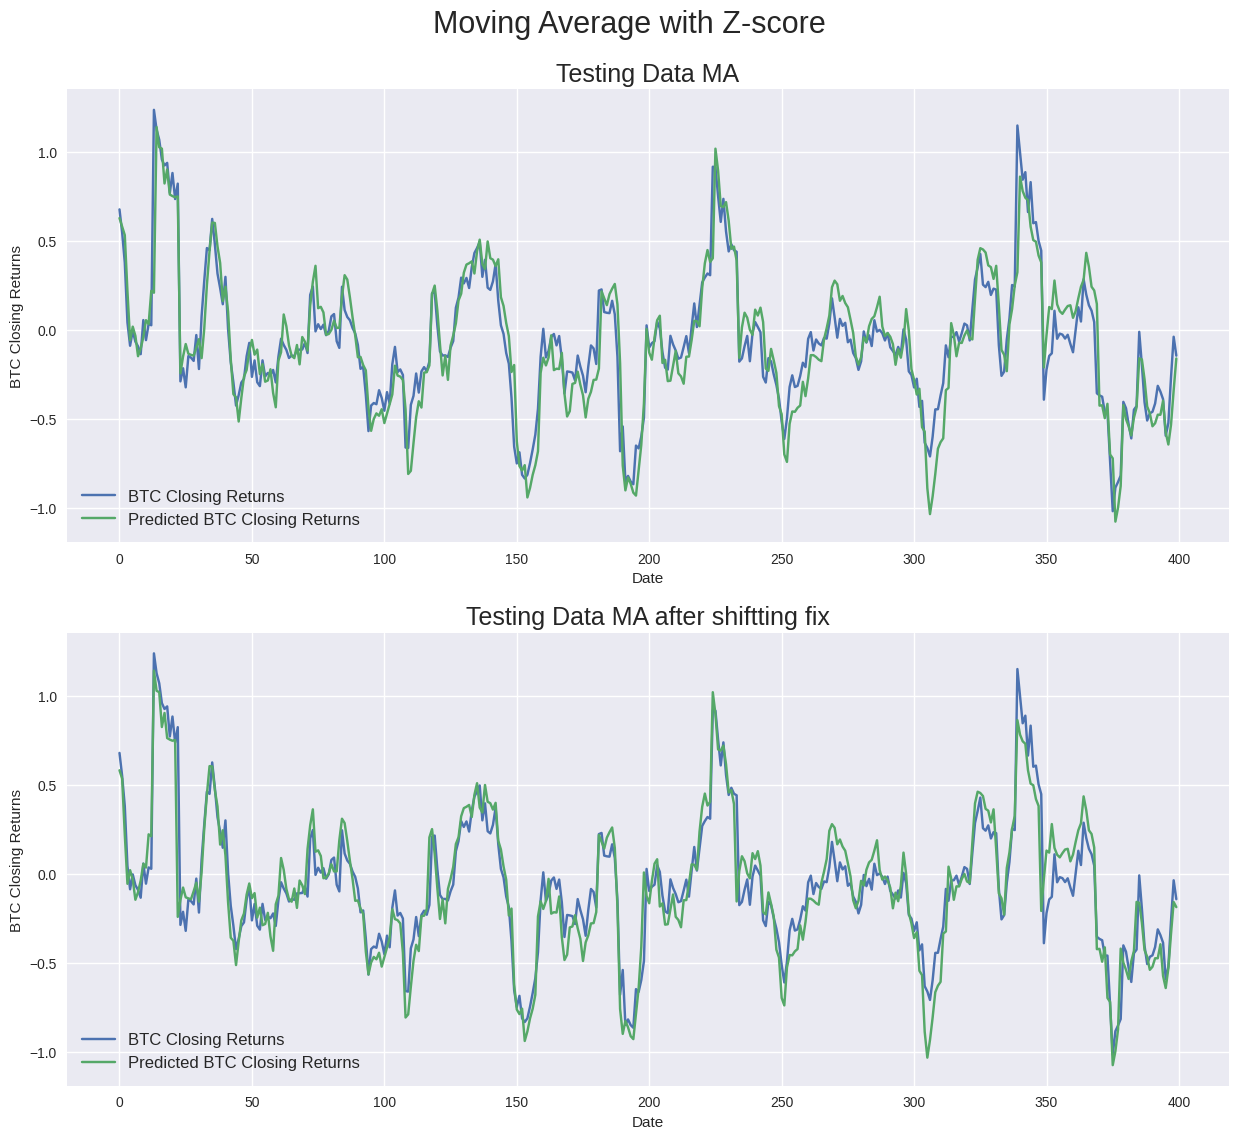

In [30]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with Z-score", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(list(y_test)[0:400], label='BTC Closing Returns')
ax11.plot(list(test_pred.reshape(-1)[0:400]), label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data MA", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot training data results
ax11 = fig.add_subplot(312)
ax11.plot(list(y_test)[0:400], label='BTC Closing Returns')
ax11.plot(list(test_pred.reshape(-1)[1:401]), label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data MA after shiftting fix", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

In [18]:
# test_pred.reshape(-1)

In [19]:
# y_test.shape[0]

In [20]:
def validation_restore_close(test_pred, df_zscore_total, seq_len=128):
    df_zscore_output = df_zscore_total.reset_index(drop=True).copy()
    df_zscore_output['pred_Close']='-'
    # 128~len(df)
    for i in range(seq_len, len(df_zscore_output)):
        # restore the model predicted_ptc
        pred_ptc = test_pred[i-seq_len]*zscore_std + zscore_mean
        # choose the single_df[0:128] (index 0~127) 
        single_df = df_zscore_output[i-seq_len:i]
        # take the final MA_10
        pre_MA = single_df['Close_MA_10'][single_df.index[-1]]
        # final MA_10* pred_ptc = pred_MA10
        close_MA = pre_MA*(pred_ptc+1)
        # pred_MA_10*10 - pre 9 Close = pred_Close
        pred_close = close_MA*10 - single_df['Close'][-9:].sum()
        df_zscore_output['pred_Close'][i] = pred_close
    return df_zscore_output

def restore_zscore_close_price_v3(test_pred, df_zscore_total, seq_len=128):
    df_zscore_output = df_zscore_total.reset_index(drop=True).copy()
    df_zscore_output['pred_Close']='-'
    # 128~len(df)
    for i in range(seq_len, len(df_zscore_output)):
        # restore the model predicted_ptc
        pred_ptc = test_pred[i-seq_len][0]*zscore_std + zscore_mean
        # choose the single_df[0:128] (index 0~127) 
        single_df = df_zscore_output[i-seq_len:i]
        # take the final MA_10
        pre_MA = single_df['Close_MA_10'][single_df.index[-1]]
        # final MA_10* pred_ptc = pred_MA10
        close_MA = pre_MA*(pred_ptc+1)
        # pred_MA_10*10 - pre 9 Close = pred_Close
        pred_close = close_MA*10 - single_df['Close'][-9:].sum()
        df_zscore_output['pred_Close'][i] = pred_close
    return df_zscore_output

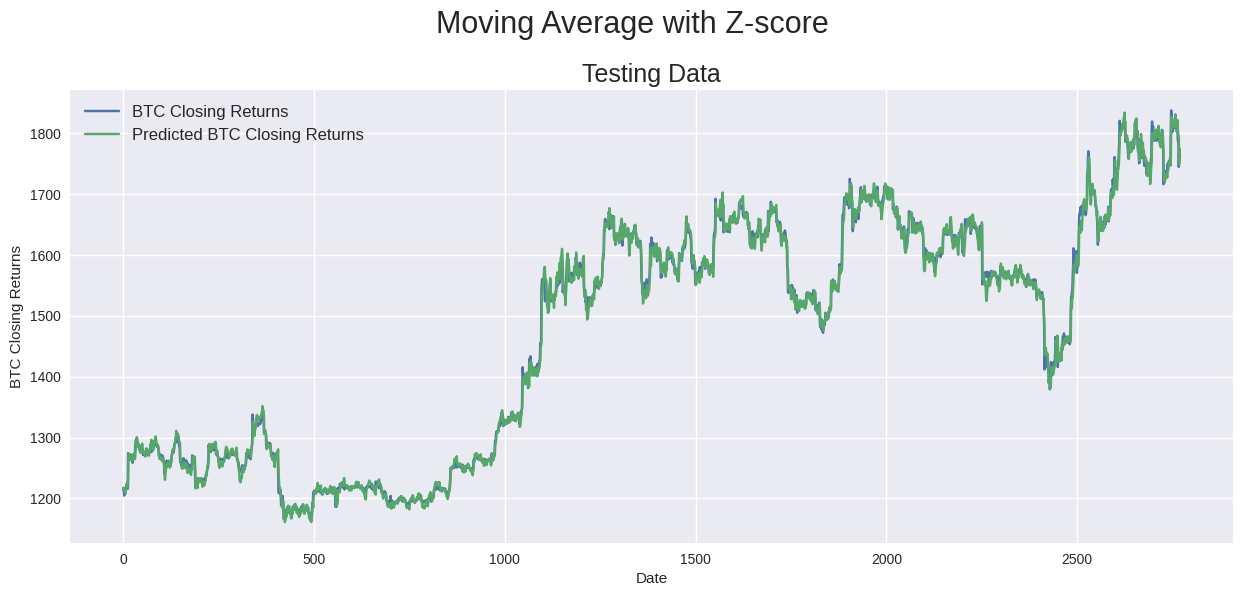

In [31]:
test = validation_restore_close(test_pred, df_test_zscore_total, seq_len=128)

# draw all testing data prediction fig

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average with Z-score", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(test['Close'][seq_len:].values, label='BTC Closing Returns')
ax11.plot(test['pred_Close'][seq_len:].values, label='Predicted BTC Closing Returns')
ax11.set_title("Testing Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

In [22]:
# df_output = restore_zscore_close_price_v3(test_pred, df_test_zscore_total, seq_len=seq_len)

In [23]:
# #df_output.to_pickle('./output_file/20230322_multi_factor_v2.0.3_testing.pickle')
# df_output = pd.read_pickle('./output_file/20230322_multi_factor_v2.0.3_testing.pickle')

In [24]:
# restored_df = df_output.copy()

In [25]:
# # draw all testing data prediction fig

# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Moving Average with Z-score", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(restored_df['Close'][seq_len:seq_len+200].values, label='BTC Closing Returns')
# ax11.plot(restored_df['pred_Close'][seq_len:seq_len+200].values, label='Predicted BTC Closing Returns')
# ax11.set_title("Testing Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('BTC Closing Returns')
# ax11.legend(loc="best", fontsize=12)

In [26]:
# # draw with first 400 testing data prediction
# seq_len = 128
# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Moving Average with Z-score", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(restored_df['Close'][-400:].values, label='BTC Closing Returns')
# ax11.plot(restored_df['pred_Close'][-400:].values, label='Predicted BTC Closing Returns')
# ax11.set_title("Testing Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('BTC Closing Returns')
# ax11.legend(loc="best", fontsize=12)

In [27]:
# # draw with first 400 testing data prediction
# seq_len = 128
# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Moving Average with Z-score", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(restored_df['Close'][-200:].values, label='BTC Closing Returns')
# ax11.plot(restored_df['pred_Close'][-200:].values, label='Predicted BTC Closing Returns')
# ax11.set_title("Testing Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('BTC Closing Returns')
# ax11.legend(loc="best", fontsize=12)

In [28]:
# restored_df[['Close','pred_Close']]